In [2]:
import os
import sys
import datetime
import glob as glob
import numpy as np
import cv2
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers, models
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

# CNN + SVM

In [94]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'Polyp_copy/train'
validation_data_dir = 'Polyp_copy/validation'

# Image generation 
train_datagen = ImageDataGenerator(
     rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
     height_shift_range=0.3,
      horizontal_flip=True,
     fill_mode='nearest'
)
 # Image generation 

validation_datagen = ImageDataGenerator(
     rescale=1./255,
     rotation_range=45,
      width_shift_range=0.3,
    height_shift_range=0.3,
      horizontal_flip=True,
     fill_mode='nearest'
)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 25

 # Standardize image size
img_rows, img_cols = 224, 224 

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 300 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [95]:
Pre_trained_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

for layer in Pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False

print()

# for layer in Pre_trained_model.layers[2:]:
#     print(layer.name)
#     layer.trainable = True


    
print(len(Pre_trained_model.layers))

input_9
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool

19


In [96]:
Pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [97]:
last_layer = Pre_trained_model.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 512)


In [98]:
# DEFINE the Model
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(2, activation='sigmoid')(x)

# Configure and compile the model

model = tf.keras.Model(Pre_trained_model.input, x)

# optimizer = Adam(learning_rate=0.001)
optimizer = SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])



# model.compile(
#             optimizer=keras.optimizers.Adadelta(),
#             loss='sparse_categorical_crossentropy',
#             metrics=['sparse_categorical_accuracy'])

# Use VGG16 as feature extraction tool and then pass the output of pretrained model as input
# Argue that you improve Random Forest Classifier - pass better features to classifier so it improves
# Get features out of VGG16 and then pass them to Random Forest Classifier

In [99]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [100]:
#Training the MODEL Feature-Extraction
#If performing fine tuning directly would result in a huge gradient, so it's better that we perform 3 epochs of 
# feature extraction first so that weights of the final fully connected layer aren't completely random. 
#The intuition for this is that if we don't perform feature-extraction, then the gradient will be too large
#and will change the pretrained weights too much.
# Enter the number of training and validation samples here
nb_train_samples = 300
nb_validation_samples = 100

# We only train 5 EPOCHS 
epochs = 50
# batch_size = 25

r = model.fit(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/50


2023-03-14 01:58:13.344524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - ETA: 0s - loss: 0.8934 - acc: 0.5000

2023-03-14 01:58:19.402514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 8s 648ms/step - loss: 0.8934 - acc: 0.5000 - val_loss: 0.7312 - val_acc: 0.5100
Epoch 2/50
12/12 [==============================] - 7s 620ms/step - loss: 0.7828 - acc: 0.5133 - val_loss: 0.7000 - val_acc: 0.5600
Epoch 3/50
12/12 [==============================] - 7s 617ms/step - loss: 0.7995 - acc: 0.4833 - val_loss: 0.6977 - val_acc: 0.5100
Epoch 4/50
12/12 [==============================] - 7s 614ms/step - loss: 0.7371 - acc: 0.5233 - val_loss: 0.7059 - val_acc: 0.4800
Epoch 5/50
12/12 [==============================] - 7s 614ms/step - loss: 0.7615 - acc: 0.4933 - val_loss: 0.6958 - val_acc: 0.4900
Epoch 6/50
12/12 [==============================] - 7s 606ms/step - loss: 0.7467 - acc: 0.5300 - val_loss: 0.7015 - val_acc: 0.4800
Epoch 7/50
12/12 [==============================] - 7s 602ms/step - loss: 0.7495 - acc: 0.4833 - val_loss: 0.6810 - val_acc: 0.5300
Epoch 8/50
12/12 [==============================] - 7s 600ms/step - loss: 0.7378 - acc:

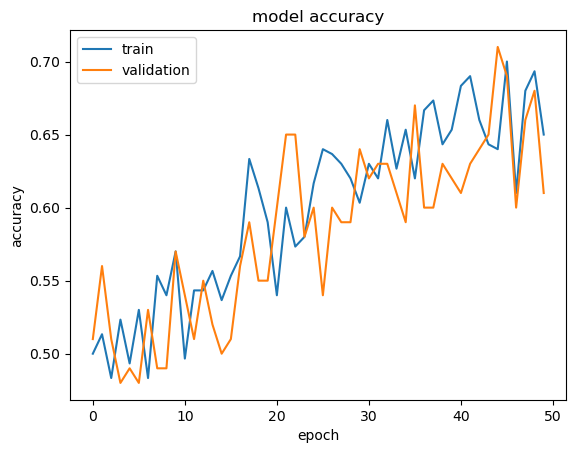

In [101]:
plt.plot(r.history['acc'])
plt.plot(r.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

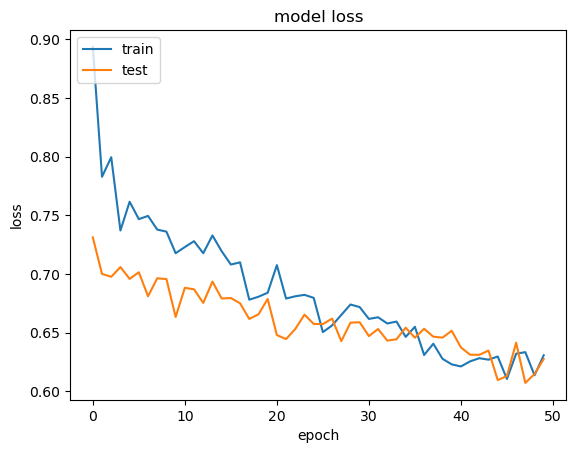

In [102]:
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [103]:
model2 = Sequential()
for layer in model.layers[:-4]:
    model2.add(layer)

In [104]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [105]:
# training data for SVM Classifier
X_train, y_train = next(train_generator)
for i in range((300//batch_size) - 1):
    img, label = next(train_generator)
    X_train = np.append(X_train, img, axis=0 )
    y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

(300, 224, 224, 3) (300, 2)


In [106]:
# validation data for SVM Classifier
X_valid, y_valid = next(validation_generator)
for i in range((100//batch_size) - 1):
    img, label = next(validation_generator)
    X_valid = np.append(X_valid, img, axis=0 )
    y_valid = np.append(y_valid, label, axis=0)
print(X_valid.shape, y_valid.shape)

(100, 224, 224, 3) (100, 2)


In [107]:
feature_mapping = model2(X_train)

In [108]:
clf = svm.SVC()

lenofimageT = len(X_train)
feature_mapping2 = np.array(feature_mapping).reshape(lenofimageT, -1)
clf.fit(feature_mapping2, y_train.argmax(axis=1))

SVC()

In [109]:
features = model2(X_valid)
lenofimageV = len(X_valid)
features2 = np.array(features).reshape(lenofimageV, -1)






In [110]:
predictionSVM = clf.predict(features2)

Accuracy = 0.67
Recall = 0.7931034482758621
Precision = 0.46


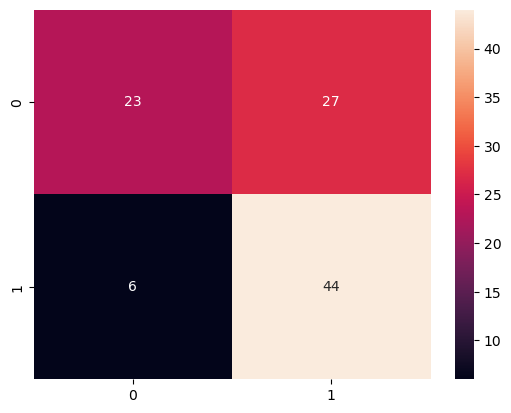

In [111]:
cm = confusion_matrix(y_valid.argmax(axis=1), predictionSVM)
sns.heatmap(cm, annot = True) 
tp, fp, fn, tn = cm.ravel()

recall = tp/(tp+fn)
precision = tp/(tp+fp)

print('Accuracy =', metrics.accuracy_score(y_valid.argmax(axis=1), predictionSVM))
print("Recall =", recall)
print("Precision =", precision)

# Simple SVM

In [112]:
# Reshape images to pass into SVM
lenofimageT = len(X_train)
lenofimageV = len(X_valid)
X_train2 = np.array(X_train).reshape(lenofimageT, -1)
X_valid2 = np.array(X_valid).reshape(lenofimageV, -1)
y_train2 = y_train.argmax(axis=1)
y_valid2 = y_valid.argmax(axis=1)

In [113]:
clf2 = svm.SVC()

In [114]:
clf2.fit(X_train2, y_train2)

SVC()

In [115]:
predictionSVM2 = clf2.predict(X_valid2)

Accuracy = 0.62
Recall = 0.65
Precision = 0.52


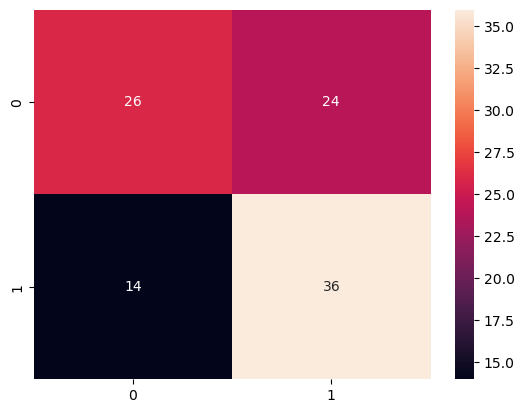

In [116]:
cm = confusion_matrix(y_valid2, predictionSVM2)
sns.heatmap(cm, annot = True) 
tp, fp, fn, tn = cm.ravel()


tp, fp, fn, tn = cm.ravel()

recall = tp/(tp+fn)
precision = tp/(tp+fp)

print('Accuracy =', metrics.accuracy_score(y_valid.argmax(axis=1), predictionSVM2))
print("Recall =", recall)
print("Precision =", precision)

# CNN + SVM 2

In [117]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'Polyp_copy/train'
validation_data_dir = 'Polyp_copy/validation'

# Image generation 
train_datagen = ImageDataGenerator(
     rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
     height_shift_range=0.3,
      horizontal_flip=True,
     fill_mode='nearest'
)
 # Image generation 

validation_datagen = ImageDataGenerator(
     rescale=1./255,
     rotation_range=45,
      width_shift_range=0.3,
    height_shift_range=0.3,
      horizontal_flip=True,
     fill_mode='nearest'
)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 25

 # Standardize image size
img_rows, img_cols = 224, 224 

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 300 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [118]:
Pre_trained_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

for layer in Pre_trained_model.layers[:2]:
    print(layer.name)
    layer.trainable = False

print()

for layer in Pre_trained_model.layers[2:]:
    print(layer.name)
    layer.trainable = True


    
print(len(Pre_trained_model.layers))

input_10
block1_conv1

block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
19


In [119]:
Pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [120]:
last_layer = Pre_trained_model.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 512)


In [121]:
# DEFINE the Model
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(2, activation='sigmoid')(x)

# Configure and compile the model

model = tf.keras.Model(Pre_trained_model.input, x)

# optimizer = Adam(learning_rate=0.001)
optimizer = SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])


# model.compile(
#             optimizer=keras.optimizers.Adadelta(),
#             loss='sparse_categorical_crossentropy',
#             metrics=['sparse_categorical_accuracy'])

# Use VGG16 as feature extraction tool and then pass the output of pretrained model as input
# Argue that you improve Random Forest Classifier - pass better features to classifier so it improves
# Get features out of VGG16 and then pass them to Random Forest Classifier

In [122]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [123]:
#Training the MODEL Feature-Extraction
#If performing fine tuning directly would result in a huge gradient, so it's better that we perform 3 epochs of 
# feature extraction first so that weights of the final fully connected layer aren't completely random. 
#The intuition for this is that if we don't perform feature-extraction, then the gradient will be too large
#and will change the pretrained weights too much.
# Enter the number of training and validation samples here
nb_train_samples = 300
nb_validation_samples = 100

# We only train 5 EPOCHS 
epochs = 50
# batch_size = 25

r = model.fit(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/50


2023-03-14 02:05:06.349637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - ETA: 0s - loss: 0.8160 - acc: 0.4400

2023-03-14 02:05:25.997016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 22s 2s/step - loss: 0.8160 - acc: 0.4400 - val_loss: 0.6853 - val_acc: 0.5500
Epoch 2/50
12/12 [==============================] - 23s 2s/step - loss: 0.7319 - acc: 0.5533 - val_loss: 0.6634 - val_acc: 0.6600
Epoch 3/50
12/12 [==============================] - 21s 2s/step - loss: 0.6856 - acc: 0.5967 - val_loss: 0.6388 - val_acc: 0.7100
Epoch 4/50
12/12 [==============================] - 21s 2s/step - loss: 0.6669 - acc: 0.6267 - val_loss: 0.6289 - val_acc: 0.7100
Epoch 5/50
12/12 [==============================] - 21s 2s/step - loss: 0.6542 - acc: 0.6600 - val_loss: 0.6215 - val_acc: 0.7200
Epoch 6/50
12/12 [==============================] - 20s 2s/step - loss: 0.6163 - acc: 0.6933 - val_loss: 0.5945 - val_acc: 0.7100
Epoch 7/50
12/12 [==============================] - 21s 2s/step - loss: 0.6021 - acc: 0.6967 - val_loss: 0.5867 - val_acc: 0.6900
Epoch 8/50
12/12 [==============================] - 21s 2s/step - loss: 0.6111 - acc: 0.6667 - val_lo

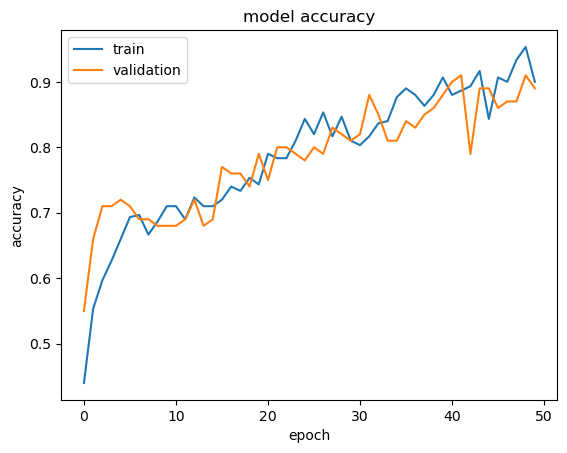

In [124]:
plt.plot(r.history['acc'])
plt.plot(r.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

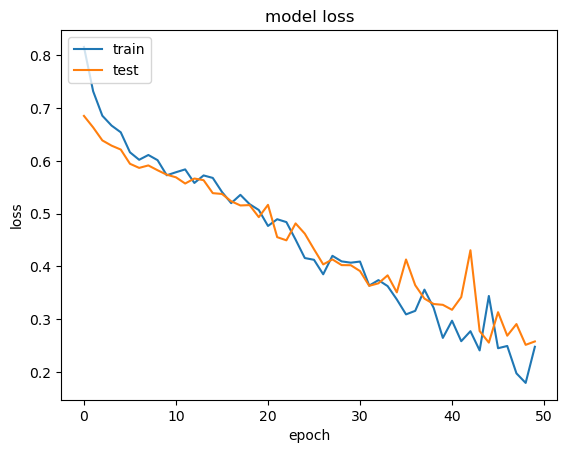

In [125]:
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [126]:
model2 = Sequential()
for layer in model.layers[:-4]:
    model2.add(layer)

In [127]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [128]:
# training data for SVM Classifier
X_train, y_train = next(train_generator)
for i in range((300//batch_size) - 1):
    img, label = next(train_generator)
    X_train = np.append(X_train, img, axis=0 )
    y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

(300, 224, 224, 3) (300, 2)


In [129]:
# validation data for SVM Classifier
X_valid, y_valid = next(validation_generator)
for i in range((100//batch_size) - 1):
    img, label = next(validation_generator)
    X_valid = np.append(X_valid, img, axis=0 )
    y_valid = np.append(y_valid, label, axis=0)
print(X_valid.shape, y_valid.shape)

(100, 224, 224, 3) (100, 2)


In [130]:
feature_mapping = model2(X_train)

In [131]:
clf = svm.SVC()

lenofimageT = len(X_train)
feature_mapping2 = np.array(feature_mapping).reshape(lenofimageT, -1)
clf.fit(feature_mapping2, y_train.argmax(axis=1))

SVC()

In [132]:
features = model2(X_valid)
lenofimageV = len(X_valid)
features2 = np.array(features).reshape(lenofimageV, -1)






In [133]:
predictionSVM = clf.predict(features2)

Accuracy = 0.83
Recall = 0.851063829787234
Precision = 0.8


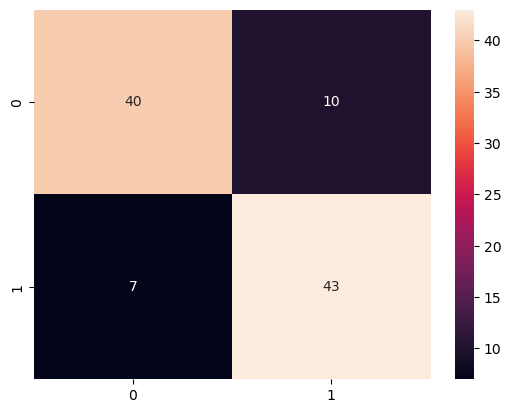

In [134]:
cm = confusion_matrix(y_valid.argmax(axis=1), predictionSVM)
sns.heatmap(cm, annot = True) 
tp, fp, fn, tn = cm.ravel()

recall = tp/(tp+fn)
precision = tp/(tp+fp)

print('Accuracy =', metrics.accuracy_score(y_valid.argmax(axis=1), predictionSVM))
print("Recall =", recall)
print("Precision =", precision)

# Simple SVM

In [135]:
# Reshape images to pass into SVM
lenofimageT = len(X_train)
lenofimageV = len(X_valid)
X_train2 = np.array(X_train).reshape(lenofimageT, -1)
X_valid2 = np.array(X_valid).reshape(lenofimageV, -1)
y_train2 = y_train.argmax(axis=1)
y_valid2 = y_valid.argmax(axis=1)

In [136]:
clf2 = svm.SVC()

In [137]:
clf2.fit(X_train2, y_train2)

SVC()

In [138]:
predictionSVM2 = clf2.predict(X_valid2)

Accuracy = 0.77
Recall = 0.813953488372093
Precision = 0.7


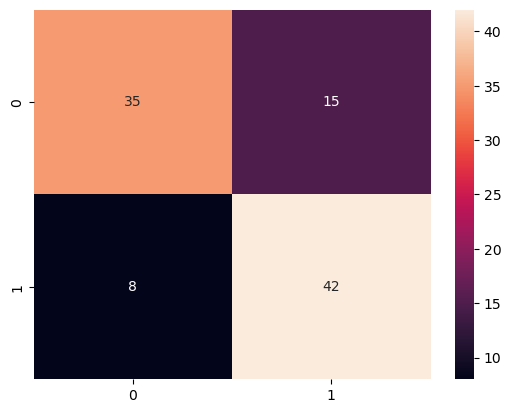

In [139]:
cm = confusion_matrix(y_valid2, predictionSVM2)
sns.heatmap(cm, annot = True) 
tp, fp, fn, tn = cm.ravel()


tp, fp, fn, tn = cm.ravel()

recall = tp/(tp+fn)
precision = tp/(tp+fp)

print('Accuracy =', metrics.accuracy_score(y_valid.argmax(axis=1), predictionSVM2))
print("Recall =", recall)
print("Precision =", precision)

# CNN + SVM 3

In [140]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'Polyp_copy/train'
validation_data_dir = 'Polyp_copy/validation'

# Image generation 
train_datagen = ImageDataGenerator(
     rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
     height_shift_range=0.3,
      horizontal_flip=True,
     fill_mode='nearest'
)
 # Image generation 

validation_datagen = ImageDataGenerator(
     rescale=1./255,
     rotation_range=45,
      width_shift_range=0.3,
    height_shift_range=0.3,
      horizontal_flip=True,
     fill_mode='nearest'
)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 25

 # Standardize image size
img_rows, img_cols = 224, 224 

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 300 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [141]:
Pre_trained_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

for layer in Pre_trained_model.layers[:-4]:
    print(layer.name)
    layer.trainable = False

print()

for layer in Pre_trained_model.layers[-4:]:
    print(layer.name)
    layer.trainable = True


    
print(len(Pre_trained_model.layers))

input_11
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool

block5_conv1
block5_conv2
block5_conv3
block5_pool
19


In [142]:
Pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [143]:
last_layer = Pre_trained_model.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 512)


In [144]:
# DEFINE the Model
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(2, activation='sigmoid')(x)

# Configure and compile the model

model = tf.keras.Model(Pre_trained_model.input, x)

# optimizer = Adam(learning_rate=0.001)
optimizer = SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])


# model.compile(
#             optimizer=keras.optimizers.Adadelta(),
#             loss='sparse_categorical_crossentropy',
#             metrics=['sparse_categorical_accuracy'])

# Use VGG16 as feature extraction tool and then pass the output of pretrained model as input
# Argue that you improve Random Forest Classifier - pass better features to classifier so it improves
# Get features out of VGG16 and then pass them to Random Forest Classifier

In [145]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [146]:
#Training the MODEL Feature-Extraction
#If performing fine tuning directly would result in a huge gradient, so it's better that we perform 3 epochs of 
# feature extraction first so that weights of the final fully connected layer aren't completely random. 
#The intuition for this is that if we don't perform feature-extraction, then the gradient will be too large
#and will change the pretrained weights too much.
# Enter the number of training and validation samples here
nb_train_samples = 300
nb_validation_samples = 100

# We only train 5 EPOCHS 
epochs = 50
# batch_size = 25

r = model.fit(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/50


2023-03-14 02:23:59.025989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - ETA: 0s - loss: 0.8282 - acc: 0.4800

2023-03-14 02:24:09.306048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 13s 1s/step - loss: 0.8282 - acc: 0.4800 - val_loss: 0.7147 - val_acc: 0.5000
Epoch 2/50
12/12 [==============================] - 11s 935ms/step - loss: 0.7425 - acc: 0.5233 - val_loss: 0.7099 - val_acc: 0.4600
Epoch 3/50
12/12 [==============================] - 10s 877ms/step - loss: 0.7363 - acc: 0.5800 - val_loss: 0.6648 - val_acc: 0.6900
Epoch 4/50
12/12 [==============================] - 11s 889ms/step - loss: 0.7117 - acc: 0.5667 - val_loss: 0.6710 - val_acc: 0.6700
Epoch 5/50
12/12 [==============================] - 11s 894ms/step - loss: 0.6719 - acc: 0.6367 - val_loss: 0.6505 - val_acc: 0.7200
Epoch 6/50
12/12 [==============================] - 11s 889ms/step - loss: 0.6738 - acc: 0.6067 - val_loss: 0.6425 - val_acc: 0.6900
Epoch 7/50
12/12 [==============================] - 11s 893ms/step - loss: 0.6702 - acc: 0.6033 - val_loss: 0.6337 - val_acc: 0.7300
Epoch 8/50
12/12 [==============================] - 11s 894ms/step - loss: 0.6492 -

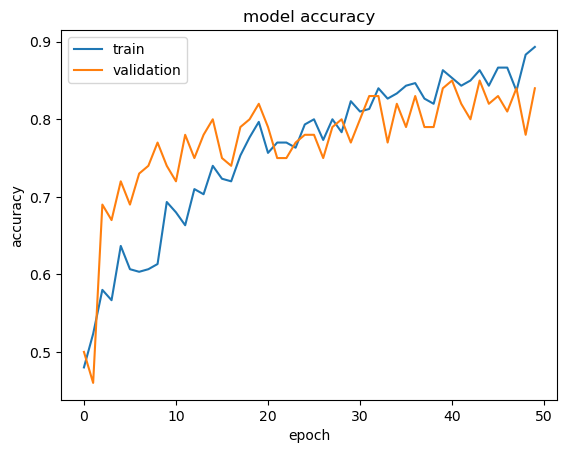

In [147]:
plt.plot(r.history['acc'])
plt.plot(r.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

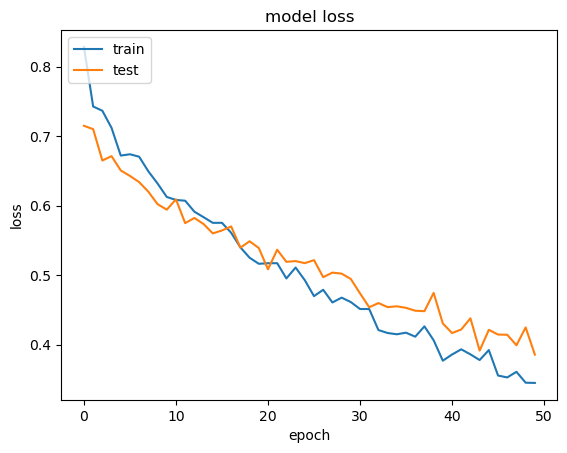

In [148]:
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [149]:
model2 = Sequential()
for layer in model.layers[:-4]:
    model2.add(layer)

In [150]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [151]:
# training data for SVM Classifier
X_train, y_train = next(train_generator)
for i in range((300//batch_size) - 1):
    img, label = next(train_generator)
    X_train = np.append(X_train, img, axis=0 )
    y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

(300, 224, 224, 3) (300, 2)


In [152]:
# validation data for SVM Classifier
X_valid, y_valid = next(validation_generator)
for i in range((100//batch_size) - 1):
    img, label = next(validation_generator)
    X_valid = np.append(X_valid, img, axis=0 )
    y_valid = np.append(y_valid, label, axis=0)
print(X_valid.shape, y_valid.shape)

(100, 224, 224, 3) (100, 2)


In [153]:
feature_mapping = model2(X_train)

In [154]:
clf = svm.SVC()

lenofimageT = len(X_train)
feature_mapping2 = np.array(feature_mapping).reshape(lenofimageT, -1)
clf.fit(feature_mapping2, y_train.argmax(axis=1))

SVC()

In [155]:
features = model2(X_valid)
lenofimageV = len(X_valid)
features2 = np.array(features).reshape(lenofimageV, -1)






In [156]:
predictionSVM = clf.predict(features2)

Accuracy = 0.82
Recall = 0.8478260869565217
Precision = 0.78


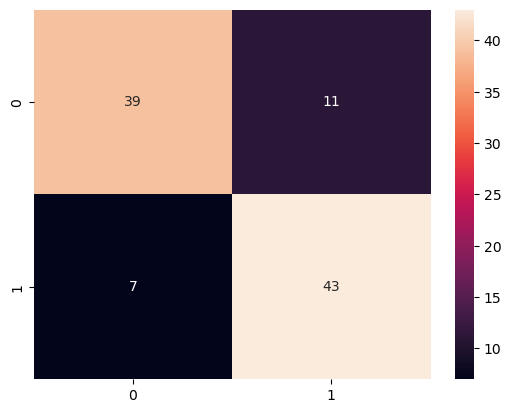

In [157]:
cm = confusion_matrix(y_valid.argmax(axis=1), predictionSVM)
sns.heatmap(cm, annot = True) 
tp, fp, fn, tn = cm.ravel()

recall = tp/(tp+fn)
precision = tp/(tp+fp)

print('Accuracy =', metrics.accuracy_score(y_valid.argmax(axis=1), predictionSVM))
print("Recall =", recall)
print("Precision =", precision)

# Simple SVM

In [158]:
# Reshape images to pass into SVM
lenofimageT = len(X_train)
lenofimageV = len(X_valid)
X_train2 = np.array(X_train).reshape(lenofimageT, -1)
X_valid2 = np.array(X_valid).reshape(lenofimageV, -1)
y_train2 = y_train.argmax(axis=1)
y_valid2 = y_valid.argmax(axis=1)

In [159]:
clf2 = svm.SVC()

In [160]:
clf2.fit(X_train2, y_train2)

SVC()

In [161]:
predictionSVM2 = clf2.predict(X_valid2)

Accuracy = 0.77
Recall = 0.8
Precision = 0.72


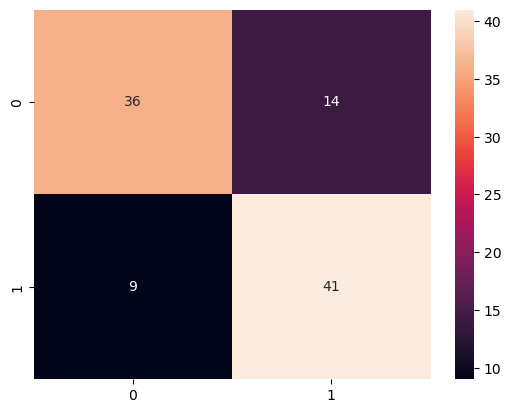

In [162]:
cm = confusion_matrix(y_valid2, predictionSVM2)
sns.heatmap(cm, annot = True) 
tp, fp, fn, tn = cm.ravel()


tp, fp, fn, tn = cm.ravel()

recall = tp/(tp+fn)
precision = tp/(tp+fp)

print('Accuracy =', metrics.accuracy_score(y_valid.argmax(axis=1), predictionSVM2))
print("Recall =", recall)
print("Precision =", precision)

# CNN 4

In [10]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'Polyp_copy/train'
validation_data_dir = 'Polyp_copy/validation'

# Image generation 
train_datagen = ImageDataGenerator(
     rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
     height_shift_range=0.3,
      horizontal_flip=True,
     fill_mode='nearest'
)
 # Image generation 

validation_datagen = ImageDataGenerator(
     rescale=1./255,
     rotation_range=45,
      width_shift_range=0.3,
    height_shift_range=0.3,
      horizontal_flip=True,
     fill_mode='nearest'
)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 25

 # Standardize image size
img_rows, img_cols = 224, 224 

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 300 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [11]:
Pre_trained_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

for layer in Pre_trained_model.layers:
    layer.trainable = True

Pre_trained_model.layers[1].trainable = False
Pre_trained_model.layers[4].trainable = False
Pre_trained_model.layers[7].trainable = False
Pre_trained_model.layers[11].trainable = False
Pre_trained_model.layers[15].trainable = False

for layer in Pre_trained_model.layers:
    print(layer.name)
    print(layer.trainable)

input_3
True
block1_conv1
False
block1_conv2
True
block1_pool
True
block2_conv1
False
block2_conv2
True
block2_pool
True
block3_conv1
False
block3_conv2
True
block3_conv3
True
block3_pool
True
block4_conv1
False
block4_conv2
True
block4_conv3
True
block4_pool
True
block5_conv1
False
block5_conv2
True
block5_conv3
True
block5_pool
True


In [12]:
Pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
last_layer = Pre_trained_model.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 512)


In [14]:
# DEFINE the Model
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(2, activation='sigmoid')(x)

# Configure and compile the model

model = tf.keras.Model(Pre_trained_model.input, x)

optimizer = SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])

In [15]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [16]:
#Training the MODEL Feature-Extraction
#If performing fine tuning directly would result in a huge gradient, so it's better that we perform 3 epochs of 
# feature extraction first so that weights of the final fully connected layer aren't completely random. 
#The intuition for this is that if we don't perform feature-extraction, then the gradient will be too large
#and will change the pretrained weights too much.
# Enter the number of training and validation samples here
nb_train_samples = 300
nb_validation_samples = 100

# We only train 5 EPOCHS 
epochs = 10
# batch_size = 25

r = model.fit(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/10


2023-03-16 10:06:08.586488: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-16 10:06:09.026828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - ETA: 0s - loss: 0.8806 - acc: 0.4767

2023-03-16 10:06:26.109058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 19s 2s/step - loss: 0.8806 - acc: 0.4767 - val_loss: 0.7121 - val_acc: 0.5000
Epoch 2/10
12/12 [==============================] - 18s 2s/step - loss: 0.7671 - acc: 0.5167 - val_loss: 0.6837 - val_acc: 0.6000
Epoch 3/10
12/12 [==============================] - 19s 2s/step - loss: 0.7093 - acc: 0.5867 - val_loss: 0.6739 - val_acc: 0.5900
Epoch 4/10
12/12 [==============================] - 18s 2s/step - loss: 0.6859 - acc: 0.5967 - val_loss: 0.6445 - val_acc: 0.6800
Epoch 5/10
12/12 [==============================] - 19s 2s/step - loss: 0.6803 - acc: 0.6067 - val_loss: 0.6276 - val_acc: 0.7100
Epoch 6/10
12/12 [==============================] - 18s 1s/step - loss: 0.6704 - acc: 0.6067 - val_loss: 0.6172 - val_acc: 0.7400
Epoch 7/10
12/12 [==============================] - 18s 2s/step - loss: 0.6406 - acc: 0.6567 - val_loss: 0.6214 - val_acc: 0.6800
Epoch 8/10
12/12 [==============================] - 18s 2s/step - loss: 0.6186 - acc: 0.6867 - val_lo

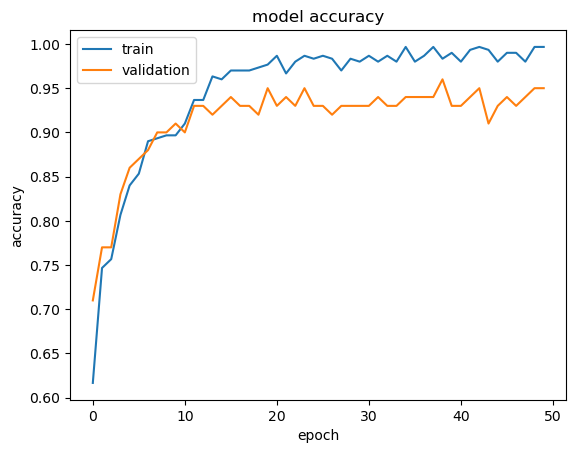

In [91]:
plt.plot(r.history['acc'])
plt.plot(r.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

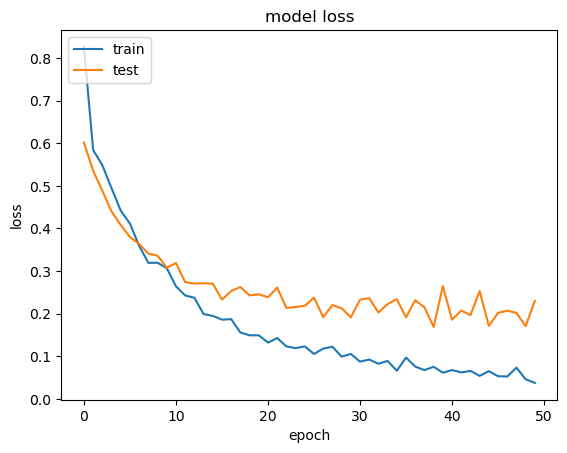

In [92]:
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()